In [5]:
pip install numpy pandas librosa matplotlib crepe tensorflow --quiet

You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [8]:
/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade matplotlib --quiet

NameError: name 'Library' is not defined

88/88 ━━━━━━━━━━━━━━━━━━━━ 26s 295ms/step
Eb major 3-oct scale + arpeggio | tuning offset: -296.0 c (subtracted)
Intonation MAE: 423.6 c | ≤10c: 8% | ≤20c: 8% | ≤30c: 8%
Timing MAE: 10565 ms | bias (−early/+late): -10565 ms


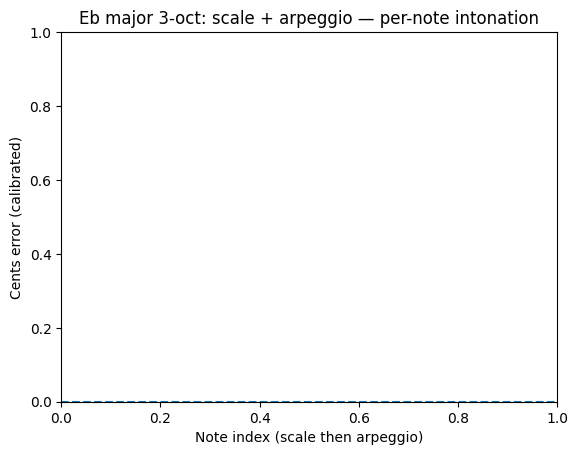

    note_index  target_hz  played_hz  cents_err
0            1     311.13     126.44    -1262.9
1            2     349.23     306.30       69.0
2            3     392.00     308.51     -118.6
3            4     415.30     349.89       -0.7
4            5     466.16     392.06       -3.7
5            6     523.25     411.36     -120.5
6            7     587.33     465.41     -106.8
7            8     622.25     524.45        0.0
8            9     698.46     589.65        2.9
9           10     783.99     596.21     -178.0
10          11     830.61     623.76     -199.8
11          12     932.33     698.56     -203.7


In [2]:
#!pip install librosa crepe numpy pandas matplotlib --quiet
import numpy as np, pandas as pd, librosa, matplotlib.pyplot as plt, crepe

# ====== CONFIGURE YOUR TAKE ======
audio_path = "/Users/jianzhulee/Downloads/clip1.wav"  # <- your recording
A4 = 440.0
use_just_intonation = False     # True for just ratios; False for equal-tempered
BPM = 72.0                      # set BPM if you used a metronome; else None

# Violin-friendly: start on Eb4 (~311 Hz) and span 3 octaves up to Eb7 (~2489 Hz)
start_note_name = 'Eb'
start_octave = 4                # Eb4
octaves = 3                     # *** three octaves ***
scale_updown = True             # scale up then down
append_arpeggio = True
arp_updown = True               # 1-3-5-8-5-3-1

# ====== MUSICAL HELPERS ======
MAJOR = [2,2,1,2,2,2,1]
JUST_MAJOR = [1, 9/8, 5/4, 4/3, 3/2, 5/3, 15/8, 2]   # degrees 1..8

NOTE2SEMI = {'C':0,'C#':1,'Db':1,'D':2,'D#':3,'Eb':3,'E':4,'F':5,'F#':6,'Gb':6,
             'G':7,'G#':8,'Ab':8,'A':9,'A#':10,'Bb':10,'B':11}
def note_to_midi(name, octave): return 12*(octave+1) + NOTE2SEMI[name]
def midi_to_hz(n, A4=440.0):   return A4 * (2 ** ((n-69)/12))
def cents(f, ft):               return 1200*np.log2(f/ft)

def build_scale_midi(tonic_midi, octaves, updown=True):
    up = [tonic_midi]
    for _ in range(octaves):
        for s in MAJOR:
            up.append(up[-1] + s)          # reaches next tonic per octave
    seq = up + (up[-2:0:-1] if updown else [])
    return seq

def build_scale_hz_just(tonic_hz, octaves, updown=True):
    up = []
    for k in range(octaves):
        up += [tonic_hz * r * (2**k) for r in JUST_MAJOR]  # 1..8 for each octave
    seq = up + (up[-2:0:-1] if updown else [])
    return np.array(seq)

def append_arpeggio_to_targets(targets_hz, tonic_hz, updown=True, just=False, A4=440.0):
    """
    Append arpeggio degrees 1,3,5,8,5,3,1 right after the scale.
    If scale went up-down, we arpeggiate from the *top tonic* (common exam pattern).
    """
    base = targets_hz[-1] if len(targets_hz)>0 else tonic_hz  # top tonic
    if just:
        degs = [1, 5/4, 3/2, 2, 3/2, 5/4, 1]
        arp = np.array([base * d for d in degs])
    else:
        # equal-tempered: 0, +4, +7, +12, +7, +4, 0 semitones from base
        midi_base = 69 + 12*np.log2(base/A4)    # fractional MIDI near base
        semis = np.array([0,4,7,12,7,4,0], dtype=float)
        arp = np.array([midi_to_hz(round(midi_base + s), A4) for s in semis])
    return np.r_[targets_hz, arp if updown else arp[:4]]  # up-only: 1,3,5,8

# ====== BUILD TARGETS: Eb major, 3 octaves, + arpeggio ======
tonic_midi = note_to_midi(start_note_name, start_octave)
tonic_hz   = midi_to_hz(tonic_midi, A4)

if use_just_intonation:
    targets_hz = build_scale_hz_just(tonic_hz, octaves, updown=scale_updown)
    if append_arpeggio:
        targets_hz = append_arpeggio_to_targets(targets_hz, tonic_hz, updown=arp_updown, just=True, A4=A4)
else:
    scale_midi = build_scale_midi(tonic_midi, octaves, updown=scale_updown)
    targets_hz = np.array([midi_to_hz(m, A4) for m in scale_midi])
    if append_arpeggio:
        targets_hz = append_arpeggio_to_targets(targets_hz, tonic_hz, updown=arp_updown, just=False, A4=A4)

# Optional labels for plotting/report
degree_labels = list(range(1, len(targets_hz)+1))

# ====== AUDIO → F0 & NOTE WINDOWS ======
sr = 16000
y, _ = librosa.load(audio_path, sr=sr, mono=True)

# F0 track (10 ms hop) for robust cents + vibrato analysis
t, f0, conf, _ = crepe.predict(y.astype(np.float32), sr, viterbi=True, step_size=10)
f0 = f0.squeeze()

# Onsets and windows (one note per beat recommended)
on_fr = librosa.onset.onset_detect(y=y, sr=sr, backtrack=True)
on_ts = librosa.frames_to_time(on_fr, sr=sr)
on_ts = np.unique(np.r_[on_ts, len(y)/sr])  # add end marker
windows = list(zip(on_ts[:-1], on_ts[1:]))

# Trim to 1–1 pairing
N = min(len(windows), len(targets_hz))
windows = windows[:N]
targets_hz = targets_hz[:N]
degree_labels = degree_labels[:N]

# ====== PER-NOTE PITCH & METRICS ======
played_hz = []
for s,e in windows:
    idx = (t>=s)&(t<e)&(f0>0)&(conf>0.6)
    played_hz.append(np.median(f0[idx]) if idx.sum() else np.nan)
played_hz = np.array(played_hz)

def robust_mae(x): 
    x = np.asarray(x, float)
    return np.nanmean(np.abs(x))

raw_cents = cents(played_hz, targets_hz)
tuning_offset = np.nanmedian(raw_cents)               # subtract overall tuning bias (e.g., A=442)
cents_err = raw_cents - tuning_offset

mae = robust_mae(cents_err)
p10 = np.nanmean(np.abs(cents_err)<=10)*100
p20 = np.nanmean(np.abs(cents_err)<=20)*100
p30 = np.nanmean(np.abs(cents_err)<=30)*100

print(f"Eb major 3-oct scale + arpeggio | tuning offset: {tuning_offset:+.1f} c (subtracted)")
print(f"Intonation MAE: {mae:.1f} c | ≤10c: {p10:.0f}% | ≤20c: {p20:.0f}% | ≤30c: {p30:.0f}%")

# Optional rhythm vs fixed beat grid (one note per beat)
if BPM is not None and N>1:
    start = windows[0][0]
    grid = start + np.arange(N)*(60.0/BPM)
    onset_err_ms = 1000*(on_ts[:N] - grid[:N])
    print(f"Timing MAE: {np.nanmean(np.abs(onset_err_ms)):.0f} ms | bias (−early/+late): {np.nanmean(onset_err_ms):+.0f} ms")

# ====== PLOTS ======
plt.figure()
#plt.stem(range(1,N+1), np.nan_to_num(cents_err), use_line_collection=True)
plt.axhline(0, linestyle='--')
plt.xlabel("Note index (scale then arpeggio)"); plt.ylabel("Cents error (calibrated)")
plt.title("Eb major 3-oct: scale + arpeggio — per-note intonation"); plt.show()

# Intonation summary table (optional)
df = pd.DataFrame({
    "note_index": range(1,N+1),
    "target_hz": np.round(targets_hz, 2),
    "played_hz": np.round(played_hz, 2),
    "cents_err": np.round(cents_err, 1)
})
print(df.head(12))


18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 300ms/step
Tuning offset (median of raw cents): +7.5 cents
Intonation (0.1s frames): MAE=8.5 c | ≤10c: 70% | ≤20c: 89%
Saved frame-by-frame results → pitch_100ms_nearest_note.csv


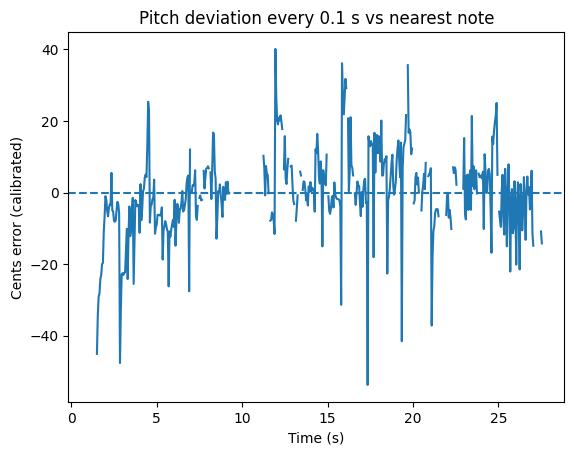

In [16]:
A4 = 440.0                                   # change to 442 if desired
conf_thresh = 0.6                            # ignore low-confidence frames
frame_ms = 50                               # == 0.1 s per frame
export_csv = "pitch_100ms_nearest_note.csv"  # set to None to skip saving
# Optional: restrict matching to certain notes (e.g., Eb major); leave None for chromatic
restrict_to_scale = None
# Example to restrict: uncomment the next line for Eb major (all octaves)
# restrict_to_scale = ["Eb","F","G","Ab","Bb","C","D"]

# ---------- HELPERS ----------
NOTE_NAMES = ["C","C#","D","Eb","E","F","F#","G","Ab","A","Bb","B"]

def hz_to_midi_contour(f_hz, A4=440.0):
    return 69.0 + 12.0*np.log2(f_hz / A4)

def midi_to_hz(n, A4=440.0):
    return A4 * (2.0 ** ((n-69.0)/12.0))

def midi_to_name(m):
    m = int(round(m))
    name = NOTE_NAMES[m % 12]
    octave = m//12 - 1
    return f"{name}{octave}"

def name_ok_for_scale(name_no_oct):
    # strip octave digits
    i = 0
    while i < len(name_no_oct) and (name_no_oct[i].isalpha() or name_no_oct[i] in ['#','b']):
        i += 1
    return name_no_oct[:i] in restrict_to_scale

# ---------- LOAD AUDIO ----------
sr = 16000
y, _ = librosa.load(audio_path, sr=sr, mono=True)

# ---------- PITCH @ 0.1 s ----------
# CREPE step_size is in milliseconds
time_s, f0_hz, conf, _ = crepe.predict(
    y.astype(np.float32), sr, viterbi=True, step_size=frame_ms
)
f0_hz = f0_hz.squeeze()

# ---------- NEAREST NOTE MATCH ----------
# Mask out invalid/low-confidence frames
valid = (f0_hz > 0) & (conf >= conf_thresh)

# continuous MIDI (can be fractional)
midi_cont = np.full_like(f0_hz, np.nan, dtype=float)
midi_cont[valid] = hz_to_midi_contour(f0_hz[valid], A4=A4)

# choose nearest chromatic MIDI by default
midi_rounded = np.full_like(midi_cont, np.nan, dtype=float)

if restrict_to_scale is None:
    # nearest integer MIDI
    midi_rounded[valid] = np.round(midi_cont[valid])
else:
    # pick nearest MIDI whose pitch class is in the allowed set
    for i, ok in enumerate(valid):
        if not ok: continue
        m_guess = round(midi_cont[i])
        # search outward until we find a note name in the allowed set
        k = 0
        while True:
            candidates = [m_guess - k, m_guess + k] if k > 0 else [m_guess]
            chosen = None; best_dist = 1e9
            for m in candidates:
                if name_ok_for_scale(midi_to_name(m)[:-1]):  # note name without octave
                    dist = abs(m - midi_cont[i])
                    if dist < best_dist:
                        best_dist = dist
                        chosen = m
            if chosen is not None:
                midi_rounded[i] = chosen
                break
            k += 1
            if k > 24:  # safety break
                midi_rounded[i] = m_guess
                break

nearest_hz = np.where(np.isfinite(midi_rounded),
                      midi_to_hz(midi_rounded, A4=A4),
                      np.nan)

# cents error (raw): positive = sharp vs nearest note
cents_err_raw = 1200.0*np.log2(np.where(nearest_hz>0, f0_hz/nearest_hz, np.nan))

# remove overall tuning bias so you see intonation around your take’s tuning
tuning_offset_cents = np.nanmedian(cents_err_raw)
cents_err_cal = cents_err_raw - tuning_offset_cents

# ---------- DATAFRAME ----------
note_names = np.array([midi_to_name(m) if np.isfinite(m) else None for m in midi_rounded])
df = pd.DataFrame({
    "time_s": time_s,
    "f0_hz": f0_hz,
    "confidence": conf,
    "nearest_note": note_names,
    "nearest_hz": nearest_hz,
    "cents_err_raw": cents_err_raw,
    "cents_err_cal": cents_err_cal
})

# keep only confident frames to compute summary
df_conf = df[df["confidence"] >= conf_thresh]

print(f"Tuning offset (median of raw cents): {tuning_offset_cents:+.1f} cents")
if not df_conf.empty:
    mae = df_conf["cents_err_cal"].abs().mean()
    p10 = (df_conf["cents_err_cal"].abs() <= 10).mean()*100
    p20 = (df_conf["cents_err_cal"].abs() <= 20).mean()*100
    print(f"Intonation (0.1s frames): MAE={mae:.1f} c | ≤10c: {p10:.0f}% | ≤20c: {p20:.0f}%")

# ---------- SAVE & PLOT ----------
if export_csv:
    df.to_csv(export_csv, index=False)
    print(f"Saved frame-by-frame results → {export_csv}")

# Plot cents error over time (calibrated)
plt.figure()
plt.plot(df["time_s"], df["cents_err_cal"])
plt.axhline(0, linestyle="--")
plt.xlabel("Time (s)"); plt.ylabel("Cents error (calibrated)")
plt.title("Pitch deviation every 0.1 s vs nearest note"); plt.show()

In [19]:
print(df.iloc[25:70])

    time_s       f0_hz  confidence nearest_note  nearest_hz  cents_err_raw  \
25    1.25  266.001505    0.141757         None         NaN            NaN   
26    1.30  259.410013    0.383423         None         NaN            NaN   
27    1.35  270.840214    0.257533         None         NaN            NaN   
28    1.40  300.025122    0.151940         None         NaN            NaN   
29    1.45  281.164860    0.464199         None         NaN            NaN   
30    1.50  304.448482    0.965742          Eb4  311.126984     -37.566484   
31    1.55  306.321227    0.967175          Eb4  311.126984     -26.949814   
32    1.60  307.263558    0.966751          Eb4  311.126984     -21.632223   
33    1.65  307.435067    0.969319          Eb4  311.126984     -20.666148   
34    1.70  308.151429    0.977160          Eb4  311.126984     -16.636850   
35    1.75  308.343457    0.978883          Eb4  311.126984     -15.558351   
36    1.80  308.897957    0.976531          Eb4  311.126984     